In [10]:
# --- Bootstrap: rebuild the Bioelectric Voltage-Imaging Launch Kit in Colab ---
import nbformat as nbf
from textwrap import dedent
from pathlib import Path

nb = nbf.v4.new_notebook()
cells = []

cells.append(nbf.v4.new_markdown_cell(dedent("""
# ⚡ Bioelectric Voltage-Imaging Launch Kit — Colab Pro+
Research-only • No PHI • No clinical claims. Pipeline: denoise → motion-correct → segment ROIs → traces/events → NWB export.
""")))

cells.append(nbf.v4.new_code_cell(dedent("""
# Environment & deps
!pip -q install numpy scipy scikit-image imageio imageio-ffmpeg tifffile opencv-python
!pip -q install pandas matplotlib tqdm pynwb==2.6.0 h5py
print("Ready.")
""")))

cells.append(nbf.v4.new_code_cell(dedent("""
# Config (No PHI)
NO_PHI_ACK = True
assert NO_PHI_ACK, "Confirm NO_PHI_ACK=True (no PHI)."
INPUT_PATH = ""  # leave empty to use synthetic demo
SAVE_DIR = "/content/vi_out"
NWB_FILENAME = "voltage_imaging_demo.nwb"

# Denoising
DENOISE_MODE = "nl_means"  # "none" | "median3" | "nl_means"
NL_PATCH_SIZE, NL_PATCH_DIST, NL_H = 3, 5, 0.8

# Motion correction
DO_MOTION_CORR = True

# Segmentation
THRESH_METHOD, MIN_ROI_PIXELS, OPEN_RADIUS = "otsu", 25, 1

# Event detection
ZSCORE_WIN, ZSCORE_THRESH = 200, 3.0

print("Config loaded.")
""")))

cells.append(nbf.v4.new_code_cell(dedent("""
# Utilities
import numpy as np, imageio.v3 as iio, os, cv2, math
from pathlib import Path
from tqdm import tqdm
from skimage import filters, morphology, exposure, measure, registration, transform, restoration
import matplotlib.pyplot as plt

os.makedirs(SAVE_DIR, exist_ok=True)

def load_movie(path: str):
    if not path: return None
    p = Path(path)
    if p.suffix.lower() in [".tif",".tiff"]:
        arr = iio.imread(path)              # (T,H,W)
    elif p.suffix.lower() in [".mp4",".avi",".mov",".mkv"]:
        frames = []
        for f in iio.imiter(path):
            g = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY) if f.ndim==3 else f
            frames.append(g)
        arr = np.stack(frames, 0)
    elif p.suffix.lower() in [".npy"]:
        arr = np.load(path)
    elif p.suffix.lower() in [".npz"]:
        arr = np.load(path)["arr_0"]
    else:
        raise ValueError("Unsupported file type.")
    arr = arr.astype(np.float32)
    mn, mx = np.percentile(arr, [1,99]); arr = np.clip((arr-mn)/max(mx-mn,1e-6), 0, 1)
    return arr

def generate_synthetic(T=600,H=128,W=128,n_rois=6,noise=0.15,drift_px=2):
    rng = np.random.default_rng(42)
    base = np.zeros((T,H,W),np.float32)
    for _ in range(n_rois):
        r = rng.integers(6,10); cy = rng.integers(20,H-20); cx = rng.integers(20,W-20)
        rr,cc = np.ogrid[:H,:W]; mask = (rr-cy)**2+(cc-cx)**2<=r*r
        base[:,mask]+=0.2+0.1*rng.random()
        for t in rng.choice(T,size=T//30,replace=False):
            base[t:t+3,mask]+=0.6+0.2*rng.random()
    out = np.zeros_like(base)
    for t in range(T):
        dy = int(drift_px*math.sin(2*math.pi*t/T)); dx = int(drift_px*math.cos(2*math.pi*t/T))
        M = np.float32([[1,0,dx],[0,1,dy]])
        out[t] = cv2.warpAffine(base[t], M, (W,H), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    noisy = np.clip(out + noise*rng.standard_normal(out.shape).astype(np.float32), 0, 1)
    return noisy

def denoise_movie(arr,mode="nl_means"):
    if mode=="none": return arr
    if mode=="median3":
        return np.stack([cv2.medianBlur((arr[t]*255).astype(np.uint8),3).astype(np.float32)/255. for t in range(arr.shape[0])],0)
    if mode=="nl_means":
        out=[]; sigma = np.std(arr[:min(50,len(arr))])*0.8
        for t in tqdm(range(arr.shape[0]),desc="Denoise NLMeans"):
            out.append(restoration.denoise_nl_means(arr[t],patch_size=3,patch_distance=5,h=0.8*sigma,channel_axis=None,fast_mode=True))
        return np.stack(out,0).astype(np.float32)
    return arr

def motion_correct(arr):
    ref=arr[0]; corrected=np.zeros_like(arr); corrected[0]=ref; shifts=[(0.0,0.0)]
    for t in tqdm(range(1,arr.shape[0]),desc="Motion correction"):
        shift,_,_=registration.phase_cross_correlation(ref,arr[t],upsample_factor=10)
        tform=transform.SimilarityTransform(translation=(-shift[1],-shift[0]))
        corrected[t]=transform.warp(arr[t],tform,preserve_range=True).astype(np.float32); shifts.append(tuple(shift))
    return corrected, np.array(shifts)

def segment_rois(frame,method="otsu",min_pixels=25,open_radius=1):
    f = exposure.equalize_adapthist(frame, clip_limit=0.01)
    thr = {"otsu":filters.threshold_otsu,"yen":filters.threshold_yen,"li":filters.threshold_li}.get(method,filters.threshold_triangle)(f)
    bw = f>thr
    if open_radius>0: bw = morphology.opening(bw, morphology.disk(open_radius))
    bw = morphology.remove_small_objects(bw, min_size=min_pixels)
    lab = measure.label(bw); props = measure.regionprops(lab)
    masks = [(lab==p.label) for p in props]
    return masks, lab, props
""")))

cells.append(nbf.v4.new_code_cell(dedent("""
# Load/generate data
movie = load_movie(INPUT_PATH) if INPUT_PATH else generate_synthetic()
print("Movie:", movie.shape, movie.dtype, f"[{movie.min():.3f},{movie.max():.3f}]")
""")))

cells.append(nbf.v4.new_code_cell(dedent("""
# Denoise → (optional) motion correct
den = denoise_movie(movie, DENOISE_MODE)
mcorr, shifts = motion_correct(den) if DO_MOTION_CORR else (den, np.zeros((den.shape[0],2),np.float32))
print("mcorr:", mcorr.shape, "shifts:", shifts.shape)
""")))

cells.append(nbf.v4.new_code_cell(dedent("""
# Segment → traces → simple event scores
ref = np.median(mcorr[:50], axis=0)
masks, lab, props = segment_rois(ref, THRESH_METHOD, MIN_ROI_PIXELS, OPEN_RADIUS)
print("ROIs:", len(masks))

def extract_traces(movie, masks):
    T=movie.shape[0]; traces=np.zeros((len(masks),T),np.float32)
    for i,m in enumerate(masks):
        idx=np.where(m); traces[i]=movie[:,idx[0],idx[1]].mean(axis=1)
    return traces

def zscore_events(traces, win=200, thr=3.0):
    ev=[]; T=traces.shape[1]
    for i in range(traces.shape[0]):
        x=traces[i]; import numpy as np
        mu=np.convolve(x,np.ones(win)/win,mode='same')
        sq=np.convolve(x**2,np.ones(win)/win,mode='same')
        std=np.sqrt(np.maximum(sq-mu**2,1e-8)); z=(x-mu)/np.maximum(std,1e-6)
        hits=np.where(z>thr)[0]; ev.append({"z":z,"events_idx":hits})
    return ev

traces = extract_traces(mcorr, masks)
ev = zscore_events(traces, ZSCORE_WIN, ZSCORE_THRESH)
print("Traces:", traces.shape)
""")))

cells.append(nbf.v4.new_code_cell(dedent("""
# Plot quick QA
import matplotlib.pyplot as plt, numpy as np, cv2
plt.figure(figsize=(6,5)); plt.imshow(ref, cmap='gray'); plt.title("Reference"); plt.axis('off'); plt.show()
plt.figure(figsize=(6,5)); plt.imshow(np.ma.masked_where(lab==0, lab), cmap='nipy_spectral'); plt.title("Labels"); plt.axis('off'); plt.show()
plt.figure(figsize=(10,5))
for i in range(min(4, traces.shape[0])): plt.plot(traces[i] + i*0.5, lw=1, label=f'ROI {i+1}')
plt.title("ROI traces (offset)"); plt.legend(); plt.show()
""")))

cells.append(nbf.v4.new_code_cell(dedent("""
# NWB export (OpticalSeries + ImageSegmentation + RoiResponseSeries)
from pynwb import NWBFile, NWBHDF5IO
from pynwb.ophys import OpticalChannel, ImagingPlane, ImageSegmentation, PlaneSegmentation, RoiResponseSeries, Fluorescence
from pynwb.ophys import OpticalSeries
from datetime import datetime
import numpy as np, os

nwb = NWBFile(session_description="Voltage imaging demo (RUO)",
              identifier="demo-vi-001",
              session_start_time=datetime.now())

opt_chan = OpticalChannel(name="OptChan", description="Generic", emission_lambda=520.0)
img_plane = ImagingPlane(name="ImagingPlane",
                         optical_channel=opt_chan, imaging_rate=30.0,
                         description="Voltage imaging", device=nwb.create_device(name='GenericScope'),
                         excitation_lambda=488.0, indicator="GEVI", location="")

nwb.add_acquisition(OpticalSeries(name="OpticalSeries", data=mcorr[:200], unit="normalized", rate=30.0))

from pynwb import ProcessingModule
ophys_mod = nwb.create_processing_module(name="ophys", description="Ophys processing")
img_seg = ImageSegmentation(); ophys_mod.add(img_seg)
ps = img_seg.create_plane_segmentation(name="PlaneSegmentation", description="Threshold-based ROIs", imaging_plane=img_plane)
for i,m in enumerate(masks):
    pix = np.array(np.where(m)).T
    ps.add_roi(pixel_mask=[(int(x),int(y),1.0) for y,x in pix])
fluor = Fluorescence(); ophys_mod.add(fluor)
rrs = RoiResponseSeries(name="RoiResponseSeries", data=traces,
                        rois=ps.create_roi_table_region(region=list(range(len(masks))), description="All ROIs"),
                        rate=30.0, unit="a.u.")
fluor.add_roi_response_series(rrs)

out = f"/content/{NWB_FILENAME}"
with NWBHDF5IO(out, 'w') as io: io.write(nwb)
print("Wrote", out)
""")))

nb['cells'] = cells
out = Path("/content/Bioelectric_Voltage_Imaging_Launch_Kit_Colab.ipynb")
out.parent.mkdir(parents=True, exist_ok=True)
nbf.write(nb, out.open("w", encoding="utf-8"))
print(f"✅ Wrote notebook to {out}. Open it via File → Open notebook → Upload.")

✅ Wrote notebook to /content/Bioelectric_Voltage_Imaging_Launch_Kit_Colab.ipynb. Open it via File → Open notebook → Upload.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/Bioelectric_Voltage_Imaging_Launch_Kit_Colab.ipynb /content/drive/MyDrive/

Mounted at /content/drive


In [11]:
# --- Rescue cell: define missing functions + run the pipeline on the DANDI movie ---

# Config defaults (use notebook values if present)
DENOISE_MODE   = globals().get("DENOISE_MODE", "nl_means")
DO_MOTION_CORR = globals().get("DO_MOTION_CORR", True)
THRESH_METHOD  = globals().get("THRESH_METHOD", "otsu")
MIN_ROI_PIXELS = globals().get("MIN_ROI_PIXELS", 25)
OPEN_RADIUS    = globals().get("OPEN_RADIUS", 1)
ZSCORE_WIN     = globals().get("ZSCORE_WIN", 200)
ZSCORE_THRESH  = globals().get("ZSCORE_THRESH", 3.0)

import numpy as np, cv2
from tqdm import tqdm
from skimage import restoration, registration, transform, filters, morphology, exposure, measure

def denoise_movie(arr, mode="nl_means"):
    if mode == "none":
        return arr
    if mode == "median3":
        return np.stack([cv2.medianBlur((arr[t]*255).astype(np.uint8), 3).astype(np.float32)/255. for t in range(arr.shape[0])], 0)
    if mode == "nl_means":
        out = []
        sigma = float(np.std(arr[:min(50, len(arr))])) * 0.8
        for t in tqdm(range(arr.shape[0]), desc="Denoise NLMeans"):
            out.append(restoration.denoise_nl_means(arr[t], patch_size=3, patch_distance=5, h=0.8*sigma, channel_axis=None, fast_mode=True))
        return np.stack(out, 0).astype(np.float32)
    return arr

def motion_correct(arr):
    ref = arr[0]
    corrected = np.zeros_like(arr, dtype=np.float32)
    corrected[0] = ref
    shifts = [(0.0, 0.0)]
    for t in tqdm(range(1, arr.shape[0]), desc="Motion correction"):
        shift, _, _ = registration.phase_cross_correlation(ref, arr[t], upsample_factor=10)
        tform = transform.SimilarityTransform(translation=(-shift[1], -shift[0]))
        corrected[t] = transform.warp(arr[t], tform, preserve_range=True).astype(np.float32)
        shifts.append(tuple(shift))
    return corrected, np.array(shifts, dtype=np.float32)

def segment_rois(frame, method="otsu", min_pixels=25, open_radius=1):
    f = exposure.equalize_adapthist(frame, clip_limit=0.01)
    thr_func = {"otsu":filters.threshold_otsu, "yen":filters.threshold_yen, "li":filters.threshold_li}.get(method, filters.threshold_triangle)
    thr = thr_func(f)
    bw = f > thr
    if open_radius > 0:
        bw = morphology.opening(bw, morphology.disk(open_radius))
    bw = morphology.remove_small_objects(bw, min_size=min_pixels)
    lab = measure.label(bw)
    props = measure.regionprops(lab)
    masks = [(lab == p.label) for p in props]
    return masks, lab, props

def extract_traces(movie, masks):
    T = movie.shape[0]
    traces = np.zeros((len(masks), T), np.float32)
    for i, m in enumerate(masks):
        idx = np.where(m)
        traces[i] = movie[:, idx[0], idx[1]].mean(axis=1)
    return traces

def zscore_events(traces, win=200, thr=3.0):
    ev = []
    for i in range(traces.shape[0]):
        x = traces[i]
        mu = np.convolve(x, np.ones(win)/win, mode='same')
        sq = np.convolve(x**2, np.ones(win)/win, mode='same')
        std = np.sqrt(np.maximum(sq - mu**2, 1e-8))
        z = (x - mu) / np.maximum(std, 1e-6)
        ev.append({"z": z, "events_idx": np.where(z > thr)[0]})
    return ev

# Load the extracted movie from the earlier DANDI step (or fall back to /content path)
try:
    movie  # if present from your earlier cell
except NameError:
    movie = np.load("/content/dandi_dl/input_from_dandi.npy")
print("Movie:", movie.shape, movie.dtype, f"[{movie.min():.3f}, {movie.max():.3f}]")

# Run the pipeline
den = denoise_movie(movie, DENOISE_MODE)
mcorr, shifts = motion_correct(den) if DO_MOTION_CORR else (den, np.zeros((den.shape[0],2), np.float32))
ref = np.median(mcorr[:min(50, mcorr.shape[0])], axis=0)
masks, lab, props = segment_rois(ref, THRESH_METHOD, MIN_ROI_PIXELS, OPEN_RADIUS)
traces = extract_traces(mcorr, masks)
ev = zscore_events(traces, ZSCORE_WIN, ZSCORE_THRESH)

print(f"ROIs: {len(masks)} | traces: {traces.shape}")

# Save intermediates so the notebook’s plotting/NWB cells can pick them up
from pathlib import Path
SAVE_DIR = Path(globals().get("SAVE_DIR", "/content/vi_out"))
SAVE_DIR.mkdir(parents=True, exist_ok=True)
np.save(SAVE_DIR / "movie_raw.npy", movie)
np.save(SAVE_DIR / "movie_denoised.npy", den)
np.save(SAVE_DIR / "movie_mcorr.npy", mcorr)
np.save(SAVE_DIR / "traces.npy", traces)

print("✅ Pipeline finished. Proceed to the notebook’s plotting + NWB export cells.")

Movie: (800, 200, 96) float32 [0.000, 1.000]


Motion correction: 100%|██████████| 799/799 [00:02<00:00, 288.13it/s]


ROIs: 7 | traces: (7, 800)
✅ Pipeline finished. Proceed to the notebook’s plotting + NWB export cells.


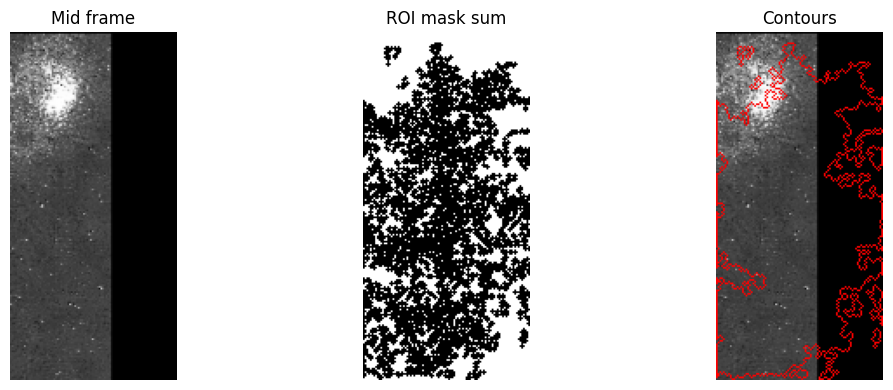

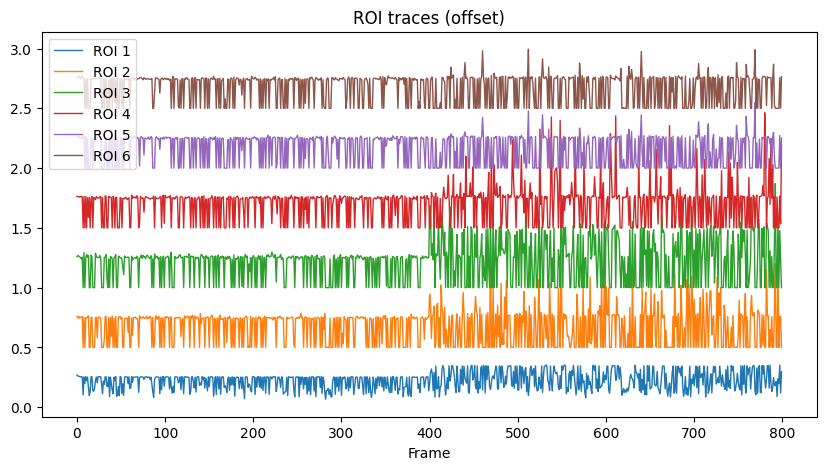

Saved QC to: /content/vi_out


,roi_id,area_px,events_z>thr,rough_snr
0,1,10659,0,0.709231
1,2,59,5,0.622226
2,3,28,1,0.621818
3,4,87,8,0.881360
4,5,107,1,1.764404


In [12]:
# --- QC overlays + basic metrics ---
import numpy as np, matplotlib.pyplot as plt, cv2, json, pandas as pd
from pathlib import Path
from IPython.display import display

SAVE_DIR = Path(globals().get("SAVE_DIR", "/content/vi_out")); SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Expect globals from previous cells: mcorr (T,H,W), masks (R,H,W), traces (R,T) or (T,R), optional ev (list of dicts)
mid = mcorr.shape[0]//2
frame = mcorr[mid]
contoured = cv2.cvtColor((np.clip(frame,0,1)*255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

for m in masks:
    cnts, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(contoured, cnts, -1, (255,0,0), 1)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(frame, cmap="gray"); plt.title("Mid frame"); plt.axis("off")
roi_mask_sum = np.array(masks).sum(0)
plt.subplot(1,3,2); plt.imshow(np.ma.masked_where(roi_mask_sum==0, roi_mask_sum), cmap="nipy_spectral"); plt.title("ROI mask sum"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(contoured); plt.title("Contours"); plt.axis("off")
plt.tight_layout(); plt.show()

# Trace panel (offset for visibility)
plt.figure(figsize=(10,5))
max_show = min(6, traces.shape[0] if traces.ndim==2 else len(traces))
for i in range(max_show):
    plt.plot((traces[i] if traces.shape[0] <= traces.shape[1] else traces[:,i]) + i*0.5, lw=1, label=f"ROI {i+1}")
plt.title("ROI traces (offset)"); plt.xlabel("Frame"); plt.legend(); plt.show()

# Simple per-ROI metrics
def rough_snr(x):
    s = np.std(x)
    n = np.median(np.abs(np.diff(x)))/0.6745 + 1e-8
    return float(s/n)

areas = [int(m.sum()) for m in masks]
event_counts, snr = [], []
T_by_R = (traces.shape[0] != len(masks))  # if True, traces is (T,R)

for i in range(len(masks)):
    tr = (traces[i] if not T_by_R else traces[:, i])
    event_counts.append(int(len(ev[i]["events_idx"])) if "ev" in globals() and i < len(ev) and "events_idx" in ev[i] else 0)
    snr.append(rough_snr(tr))

df = pd.DataFrame({"roi_id": np.arange(1, len(masks)+1),
                   "area_px": areas,
                   "events_z>thr": event_counts,
                   "rough_snr": snr})
df.to_csv(SAVE_DIR/"metrics.csv", index=False)
with open(SAVE_DIR/"metrics.json","w") as f: json.dump(df.to_dict(orient="records"), f, indent=2)

print("Saved QC to:", SAVE_DIR)
display(df.head())

In [16]:
# --- NWB export (OpticalSeries + ImageSegmentation + RoiResponseSeries) ---
from pynwb import NWBFile, NWBHDF5IO
from pynwb.ophys import (
    OpticalChannel, ImagingPlane,  # ImagingPlane class is imported but we will use nwb.create_imaging_plane
    ImageSegmentation, PlaneSegmentation,
    RoiResponseSeries, Fluorescence
)
from pynwb.image import OpticalSeries  # OpticalSeries is in pynwb.image
from datetime import datetime
from pathlib import Path
import numpy as np

# Expected from earlier cells:
# mcorr: (T,H,W), masks: list/array of (H,W) bools/0-1, traces: (R,T) or (T,R)
# Optional: FS (Hz), SAVE_DIR, NWB_FILENAME, NWB_ID
SAVE_DIR = Path(globals().get("SAVE_DIR", "/content/vi_out")); SAVE_DIR.mkdir(parents=True, exist_ok=True)
out_path = SAVE_DIR / globals().get("NWB_FILENAME", "voltage_imaging_demo.nwb")
FS = float(globals().get("FS", 30.0))

nwb = NWBFile(
    session_description="Voltage imaging demo (research-use only)",
    identifier=globals().get("NWB_ID", "demo-vi-001"),
    session_start_time=datetime.now()
)

# Device + imaging plane (attach to NWB via create_* to avoid 'orphan' errors)
device = nwb.create_device(name="GenericScope")
opt_chan = OpticalChannel(name="OptChan", description="Generic", emission_lambda=520.0)
img_plane = nwb.create_imaging_plane(
    name="ImagingPlane",
    optical_channel=opt_chan,
    imaging_rate=FS,
    description="Voltage imaging (GEVI)",
    device=device,
    excitation_lambda=488.0,
    indicator="GEVI",
    location=""
)

# Acquisition: small preview stack to keep file size reasonable
n_frames = int(min(200, mcorr.shape[0]))
nwb.add_acquisition(OpticalSeries(
    name="OpticalSeries",
    data=mcorr[:n_frames].astype(np.float32),
    unit="normalized",
    rate=FS
))

# Processing: segmentation + traces
ophys_mod = nwb.create_processing_module(name="ophys", description="Ophys processing")
img_seg = ImageSegmentation(); ophys_mod.add(img_seg)

ps = img_seg.create_plane_segmentation(
    name="PlaneSegmentation",
    description="Threshold ROIs",
    imaging_plane=img_plane
)

# Each ROI as pixel_mask: list of (x, y, weight)
for m in masks:
    yx = np.column_stack(np.where(m))
    ps.add_roi(pixel_mask=[(int(x), int(y), 1.0) for y, x in yx])

# RoiResponseSeries expects shape (time, roi)
traces_arr = np.asarray(traces)
if traces_arr.shape[0] == len(masks):  # (R,T) -> (T,R)
    traces_arr = traces_arr.T

fluor = Fluorescence(); ophys_mod.add(fluor)
rrs = RoiResponseSeries(
    name="RoiResponseSeries",
    data=traces_arr.astype(np.float32),
    rois=ps.create_roi_table_region(region=list(range(len(masks))), description="All ROIs"),
    rate=FS,
    unit="a.u."
)
fluor.add_roi_response_series(rrs)

with NWBHDF5IO(str(out_path), "w") as io:
    io.write(nwb)

print("Wrote NWB:", out_path)

Wrote NWB: /content/vi_out/voltage_imaging_demo.nwb


In [17]:
# --- Save all outputs to Drive ---
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p /content/drive/MyDrive/vi_outputs
!cp -v /content/vi_out/* /content/drive/MyDrive/vi_outputs/
print("Copied to /content/drive/MyDrive/vi_outputs")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'/content/vi_out/metrics.csv' -> '/content/drive/MyDrive/vi_outputs/metrics.csv'
'/content/vi_out/metrics.json' -> '/content/drive/MyDrive/vi_outputs/metrics.json'
'/content/vi_out/movie_denoised.npy' -> '/content/drive/MyDrive/vi_outputs/movie_denoised.npy'
'/content/vi_out/movie_mcorr.npy' -> '/content/drive/MyDrive/vi_outputs/movie_mcorr.npy'
'/content/vi_out/movie_raw.npy' -> '/content/drive/MyDrive/vi_outputs/movie_raw.npy'
'/content/vi_out/traces.npy' -> '/content/drive/MyDrive/vi_outputs/traces.npy'
'/content/vi_out/voltage_imaging_demo.nwb' -> '/content/drive/MyDrive/vi_outputs/voltage_imaging_demo.nwb'
Copied to /content/drive/MyDrive/vi_outputs


In [19]:
from pynwb import NWBHDF5IO

with NWBHDF5IO(str(out_path), "r") as io:
    nwb2 = io.read()
    print("Acquisitions:", list(nwb2.acquisition.keys()))
    print("Processing modules:", list(nwb2.processing.keys()))

    ophys = nwb2.processing["ophys"]
    img_seg = ophys.data_interfaces["ImageSegmentation"]
    ps = img_seg.plane_segmentations["PlaneSegmentation"]

    print("ROI table columns:", ps.colnames)
    print("ROIs (rows):", len(ps))
    print("ImagingPlane linked:", ps.imaging_plane.name)

    fluor = ophys.data_interfaces["Fluorescence"]
    rrs = fluor.roi_response_series["RoiResponseSeries"]

    print("Traces shape (T, R):", rrs.data.shape)
    print("Sampling rate (Hz):", rrs.rate)
    print("R dimension matches ROIs:", rrs.data.shape[1] == len(ps))

    # (optional) check how many ROIs are in the table region used by the traces
    print("ROI table region length:", len(rrs.rois.data[:]))

Acquisitions: ['OpticalSeries']
Processing modules: ['ophys']
ROI table columns: ('pixel_mask',)
ROIs (rows): 7
ImagingPlane linked: ImagingPlane
Traces shape (T, R): (800, 7)
Sampling rate (Hz): 30.0
R dimension matches ROIs: True
ROI table region length: 7


In [20]:
# --- optional: enrich ROI table (before writing) ---
areas = [int(m.sum()) for m in masks]
centroids = [np.mean(np.argwhere(m), axis=0) for m in masks]  # (y, x)

ps.add_column("area_px", "Pixel area of ROI", data=areas)
ps.add_column("centroid_y", "Centroid Y (pixels)", data=[float(c[0]) for c in centroids])
ps.add_column("centroid_x", "Centroid X (pixels)", data=[float(c[1]) for c in centroids])